In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from flask import Flask, jsonify

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# # place holder in case of wanting to inspect the engine to show properties/ methods
# # if need to use, highlight everything in this line and hit Crl + / for windows and Cmd + / for MacOS

# inspector = inspect(engine)
# dir(inspector)

In [7]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)

# reflect the tables
tables = Base.classes.keys()

In [8]:
# show all of the classes that automap found
tables

['measurement', 'station']

In [9]:
# Save references to each table
station = Base.classes['station']
measurement = Base.classes['measurement']

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [11]:
# inspect the measurement table to find column names
dir(measurement)[-10:]

['_sa_decl_prepare',
 '_sa_raise_deferred_config',
 'classes',
 'date',
 'id',
 'metadata',
 'prcp',
 'prepare',
 'station',
 'tobs']

# Exploratory Climate Analysis

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# use timedelta to calculate query_date
prp_tpl = session.query(measurement.date, measurement.prcp).all() # list of tuples
last_date = dt.datetime.strptime(prp_tpl[-1][0], '%Y-%m-%d')

# Calculate the date 1 year ago from the last data point in the database & convert data into dataframe
query_date  = last_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
prp_tpl = session.query(measurement.date, measurement.prcp).filter(measurement.date > query_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prp_df = pd.DataFrame(prp_tpl,columns=['Date', 'Precipitation'])
prp_df.set_index('Date', inplace=True)

# Sort the dataframe by date
prp_df.sort_index(inplace=True)
prp_df

,Precipitation
Date,
2016-08-24,0.08
2016-08-24,NaN
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15
...,...
2017-08-22,0.00
2017-08-23,0.08
2017-08-23,0.00


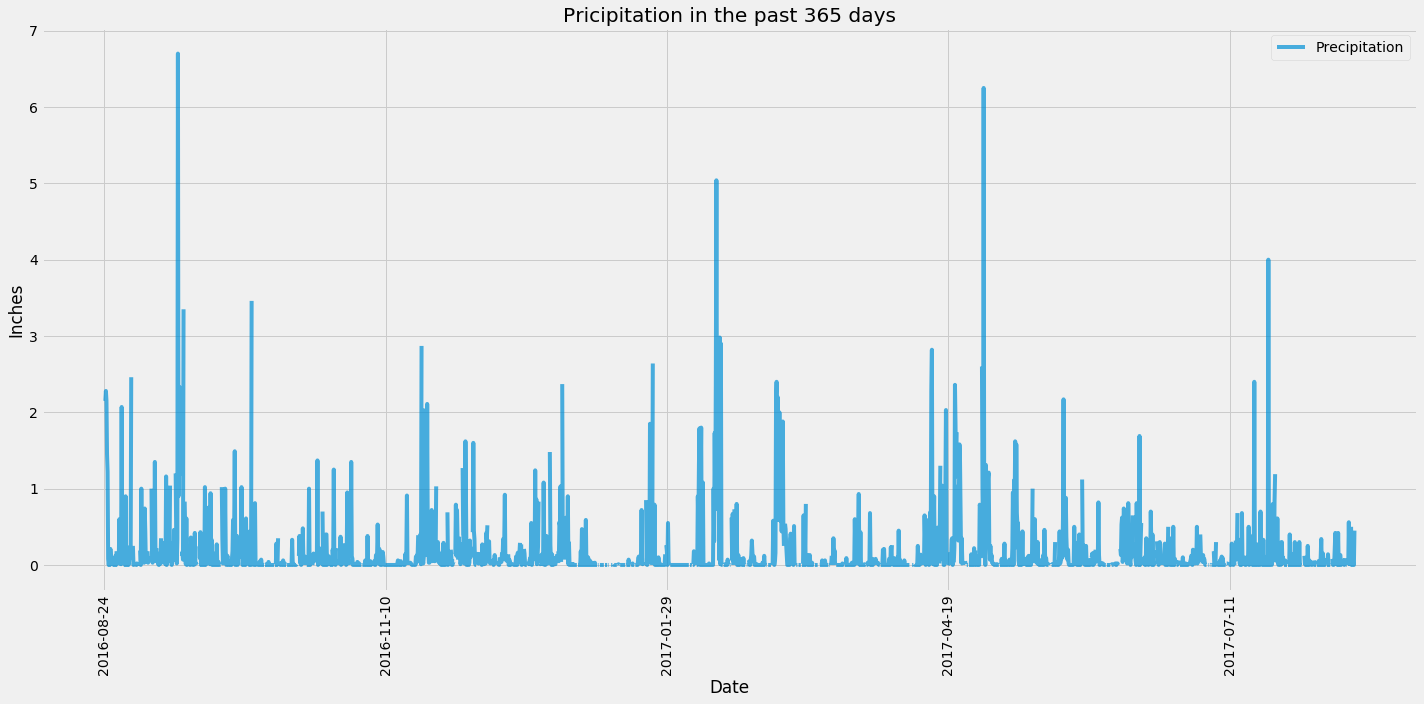

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data
prp_df.plot(figsize=(20,10), rot=90, alpha=0.7) # pandas command

# use Matplotlib to decorate
plt.title("Pricipitation in the past 365 days") # create title
plt.xlabel("Date") 
plt.ylabel("Inches")

# to prevent x-asis cut off, use the tight layout or can also use:
            # from matplotlib import rcParams
            # rcParams.update({'figure.autolayout': True})
plt.tight_layout()


# save fig to Images folder
plt.savefig("Images/Precipitation_last1yr.png")

# show all layers on the final charts
plt.show()

In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data
prp_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [15]:
dir(station)[-10:]

['_sa_raise_deferred_config',
 'classes',
 'elevation',
 'id',
 'latitude',
 'longitude',
 'metadata',
 'name',
 'prepare',
 'station']

In [16]:
# Design a query to show how many stations are available in this dataset?
session.query(station.id).count()

9

In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
prp_station = session.query(measurement.station,func.count(measurement.station))\
                            .group_by(measurement.station)\
                            .order_by(func.count(measurement.station).desc()).all()


# List the stations and the counts in descending order.
prp_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
# observation : 
    # the most active station is the one with highest row counts, since the list was sorted ascending, index = 0 is the top station

top_station_id = prp_station[0][0]
topstation_MINtemp = session.query(func.min(measurement.tobs)).filter_by(station = top_station_id).first()[0]
topstation_AVEtemp = round(session.query(func.avg(measurement.tobs)).filter_by(station = top_station_id).first()[0], 0)
topstation_MAXtemp = session.query(func.max(measurement.tobs)).filter_by(station = top_station_id).first()[0]
print(f'>> Station : {top_station_id}\n\
    * Min Temperature : {topstation_MINtemp} deg-F\n\
    * Max Temperature : {topstation_MAXtemp} deg-F\n\
    * Average Temperature : {topstation_AVEtemp} deg-F')


>> Station : USC00519281
    * Min Temperature : 54.0 deg-F
    * Max Temperature : 85.0 deg-F
    * Average Temperature : 72.0 deg-F


In [19]:
# Choose the station with the highest number of temperature observations.
rectemp_station = session.query(measurement.station, func.max(measurement.tobs)).first()
rectemp_st_name = rectemp_station[0]
print(f'>> Max Temp Recorded:\n\t Station : {rectemp_st_name}')

>> Max Temp Recorded:
	 Station : USC00519397


In [20]:
# Query the last 12 months of temperature observation data for this station 
rectemp_data = session.query(measurement.date, measurement.tobs)\
    .filter(measurement.station == rectemp_st_name)\
    .filter(measurement.date > query_date).all()
rectemp_data[:10]

[('2016-08-24', 79.0),
 ('2016-08-25', 80.0),
 ('2016-08-26', 79.0),
 ('2016-08-27', 77.0),
 ('2016-08-28', 78.0),
 ('2016-08-29', 78.0),
 ('2016-08-30', 79.0),
 ('2016-08-31', 80.0),
 ('2016-09-01', 81.0),
 ('2016-09-02', 80.0)]

In [21]:
# convert tuple list of temperature data for this station in to a dataframe for plotting
rectemp_df = pd.DataFrame(rectemp_data,columns=['Date', 'Temperature'])
# rectemp_df.set_index('Date', inplace=True)
rectemp_df

,Date,Temperature
0,2016-08-24,79.0
1,2016-08-25,80.0
2,2016-08-26,79.0
3,2016-08-27,77.0
4,2016-08-28,78.0
...,...,...
355,2017-08-19,79.0
356,2017-08-20,81.0
357,2017-08-21,81.0
358,2017-08-22,82.0


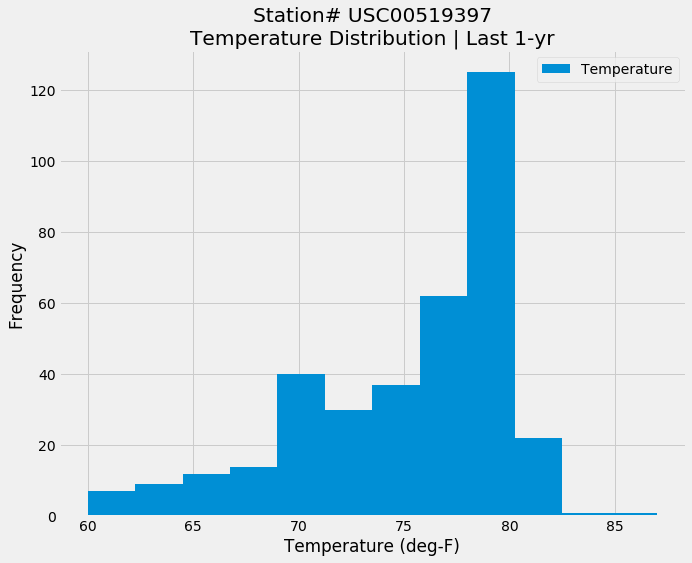

In [22]:
# plot the results as a histogram
rectemp_df.hist(figsize=(10, 8), bins=12)
plt.legend(['Temperature'])
plt.xlabel('Temperature (deg-F)')
plt.ylabel('Frequency')

# I like to build a flexible code where things change when database is changed
# so I create f-string with changeable station name to plot and to export graph
plt.title(f'Station# {rectemp_st_name}\nTemperature Distribution | Last 1-yr')
plt.savefig(f'Images/{rectemp_st_name}_Temp_Histogram_1yr.png')

## Bonus Challenge Assignment

In [23]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).first()



(62.0, 69.57142857142857, 74.0)


In [28]:
# calculate the tmin, tavg, and tmax using <calc_temps> function
# for trip using the previous year's data for those same dates.

print(calc_temps('2017-02-02', '2017-03-02'))


(59.0, 70.03825136612022, 80.0)


In [25]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [26]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [27]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

NameError: name 'Measurement' is not defined

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
